Add Starting Pitching to Model

    In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp5.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [5]:
hv_mean = df_train.home_victory.mean()

0.5390217540488609

FIRST -- Just add in ERA and WHIP over last 35 games (in addition to first model params)

In [6]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [7]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((116576, 8), (10611, 8), (4852, 8))

In [9]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689532
[20]	valid_0's binary_logloss: 0.688515
[30]	valid_0's binary_logloss: 0.687653
[40]	valid_0's binary_logloss: 0.686882
[50]	valid_0's binary_logloss: 0.686191
[60]	valid_0's binary_logloss: 0.685618
[70]	valid_0's binary_logloss: 0.685126
[80]	valid_0's binary_logloss: 0.684672
[90]	valid_0's binary_logloss: 0.684295
[100]	valid_0's binary_logloss: 0.683952
[110]	valid_0's binary_logloss: 0.683626
[120]	valid_0's binary_logloss: 0.683314
[130]	valid_0's binary_logloss: 0.683053
[140]	valid_0's binary_logloss: 0.682766
[150]	valid_0's binary_logloss: 0.682555
[160]	valid_0's binary_logloss: 0.682336
[170]	valid_0's binary_logloss: 0.682103
[180]	valid_0's binary_logloss: 0.681893
[190]	valid_0's binary_logloss: 0.681707
[200]	valid_0's binary_logloss: 0.681532
[210]	valid_0's binary_logloss: 0.681403
[220]	valid_0's binary_logloss: 0.681234
[230]	valid_0's binary_logloss: 0.681112
[240]

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [10]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [11]:
# previous model gave 0.683490243306594
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6743975768084609, 0.6904962611329533)

In [12]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

In [13]:
# naive-LV, naive-simp_mod, naive-current_mod

np.round([.6904 - .6675, .6904-.6830, .6904-.6747], decimals=4)

array([0.0229, 0.0074, 0.0157])

In [14]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

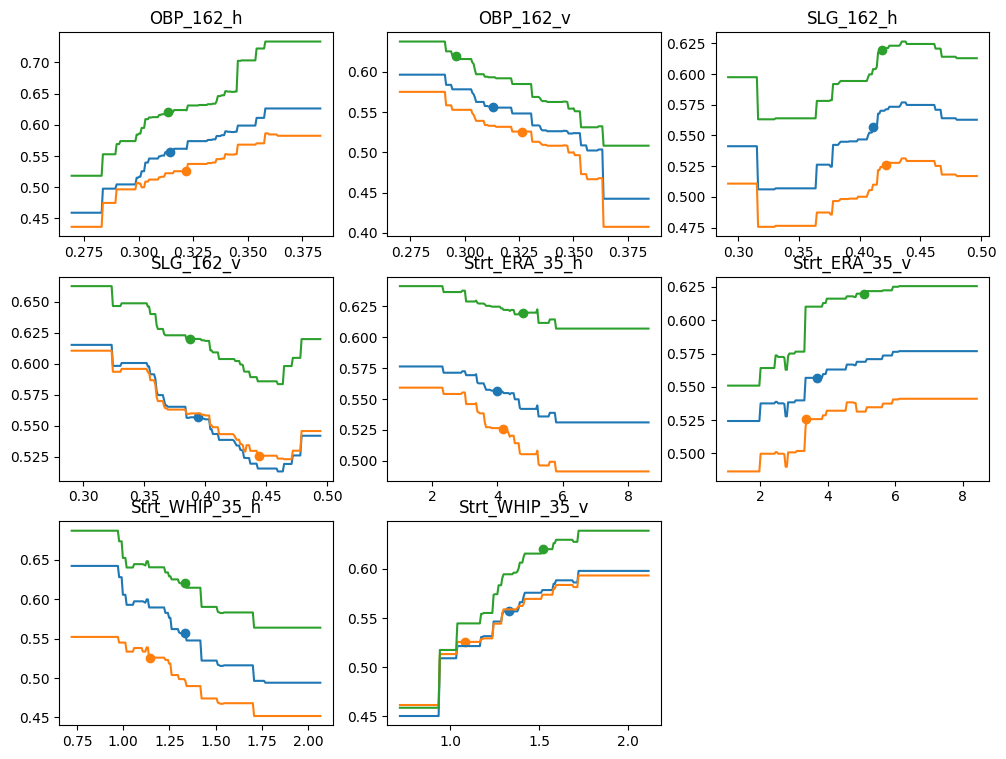

In [15]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

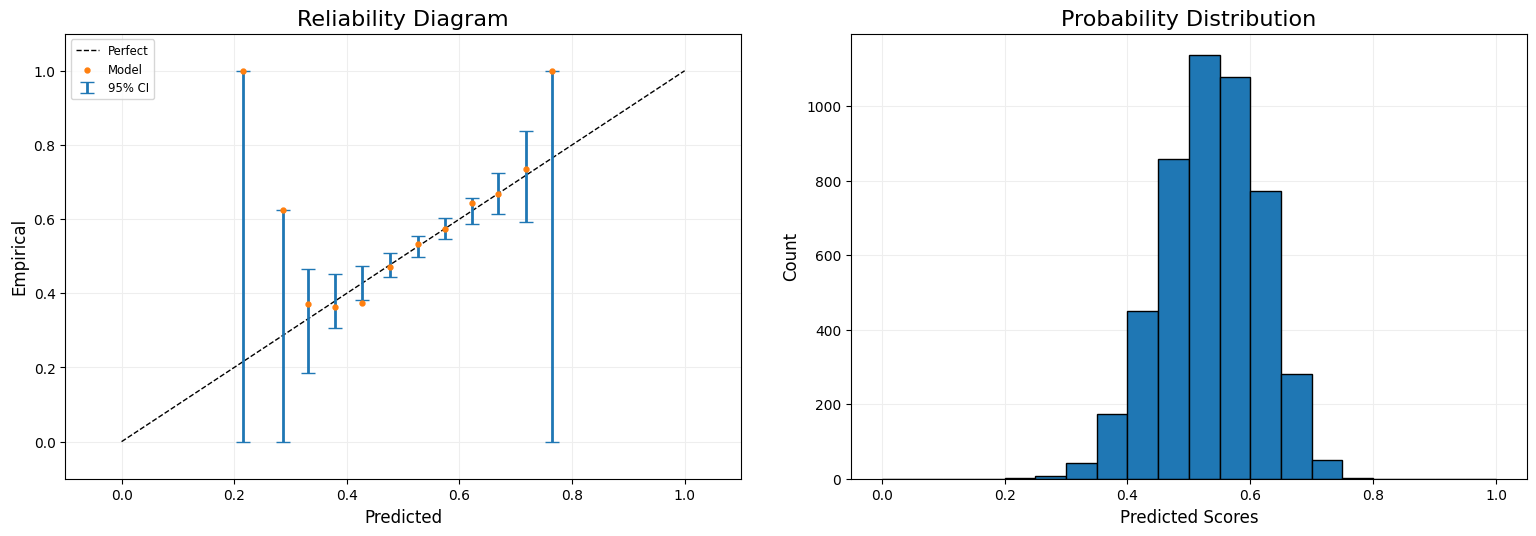

In [16]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [17]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [18]:
# This shows for each game, how the different features affected 

sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.055,0.063,0.116,-0.002,0.044,0.033,0.171,0.059,0.159
1,-0.071,0.030,0.090,0.009,0.011,-0.098,0.101,-0.191,0.159
2,-0.018,0.005,0.104,-0.067,-0.103,-0.111,0.079,-0.217,0.159
3,-0.204,0.014,-0.015,-0.069,0.030,-0.074,0.031,-0.125,0.159
4,-0.053,0.009,0.073,-0.103,0.031,0.003,0.105,-0.410,0.159


In [24]:
df_test.pitcher_start_name_v.iloc[5]

'Max Fried'

In [25]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.158957
Strt_WHIP_35_h    0.098051
Strt_WHIP_35_v    0.081000
OBP_162_h         0.077513
OBP_162_v         0.060111
SLG_162_h         0.054330
SLG_162_v         0.052466
Strt_ERA_35_v     0.050781
Strt_ERA_35_h     0.042671
dtype: float64

Let's add in a few more pitching features...

In [26]:
# Add in SO% and "Modified Slugging Against"

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'

In [27]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [28]:
X_train.shape, X_valid.shape, X_test.shape

((116576, 14), (10611, 14), (4852, 14))

In [29]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689524
[20]	valid_0's binary_logloss: 0.688513
[30]	valid_0's binary_logloss: 0.68762
[40]	valid_0's binary_logloss: 0.686816
[50]	valid_0's binary_logloss: 0.686132
[60]	valid_0's binary_logloss: 0.685438
[70]	valid_0's binary_logloss: 0.684907
[80]	valid_0's binary_logloss: 0.68448
[90]	valid_0's binary_logloss: 0.684032
[100]	valid_0's binary_logloss: 0.683585
[110]	valid_0's binary_logloss: 0.683224
[120]	valid_0's binary_logloss: 0.682836
[130]	valid_0's binary_logloss: 0.682524
[140]	valid_0's binary_logloss: 0.682204
[150]	valid_0's binary_logloss: 0.681973
[160]	valid_0's binary_logloss: 0.681682
[170]	valid_0's binary_logloss: 0.681486
[180]	valid_0's binary_logloss: 0.681291
[190]	valid_0's binary_logloss: 0.681075
[200]	valid_0's binary_logloss: 0.680931
[210]	valid_0's binary_logloss: 0.680754
[220]	valid_0's binary_logloss: 0.680619
[230]	valid_0's binary_logloss: 0.680482
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [30]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [31]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6745532281574, 0.6904962611329533)

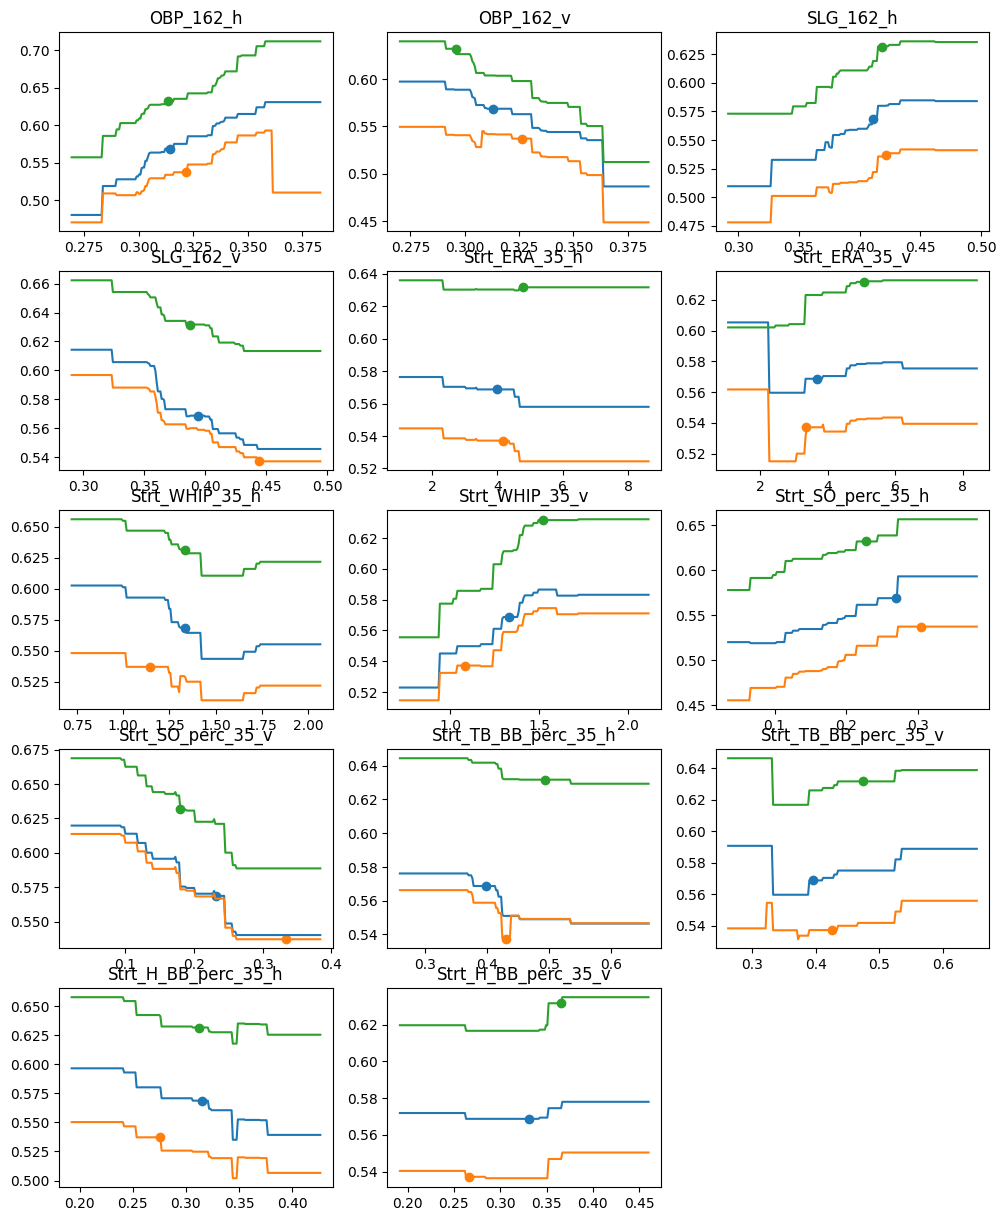

In [32]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

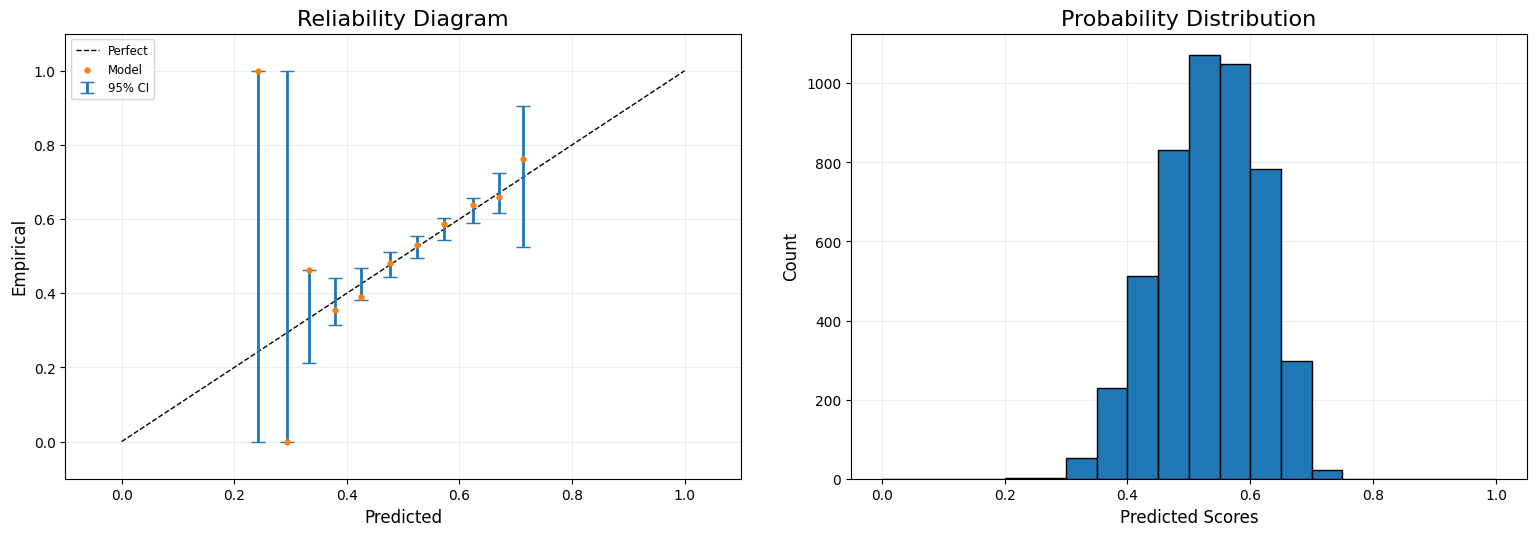

In [33]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [34]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [35]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.158939
Strt_SO_perc_35_v       0.114479
Strt_SO_perc_35_h       0.087026
OBP_162_h               0.072201
Strt_WHIP_35_h          0.060365
OBP_162_v               0.056178
Strt_WHIP_35_v          0.054768
SLG_162_h               0.049352
SLG_162_v               0.041598
Strt_ERA_35_v           0.034449
Strt_TB_BB_perc_35_h    0.031156
Strt_H_BB_perc_35_h     0.030661
Strt_TB_BB_perc_35_v    0.014952
Strt_ERA_35_h           0.013000
Strt_H_BB_perc_35_v     0.010853
dtype: float64

In [36]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'

In [37]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [38]:
X_train.shape, X_valid.shape, X_test.shape

((116576, 20), (10611, 20), (4852, 20))

In [39]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689532
[20]	valid_0's binary_logloss: 0.688491
[30]	valid_0's binary_logloss: 0.687594
[40]	valid_0's binary_logloss: 0.686856
[50]	valid_0's binary_logloss: 0.686251
[60]	valid_0's binary_logloss: 0.685637
[70]	valid_0's binary_logloss: 0.685157
[80]	valid_0's binary_logloss: 0.684728
[90]	valid_0's binary_logloss: 0.684409
[100]	valid_0's binary_logloss: 0.684005
[110]	valid_0's binary_logloss: 0.683659
[120]	valid_0's binary_logloss: 0.683295
[130]	valid_0's binary_logloss: 0.682981
[140]	valid_0's binary_logloss: 0.682722
[150]	valid_0's binary_logloss: 0.682453
[160]	valid_0's binary_logloss: 0.682212
[170]	valid_0's binary_logloss: 0.68197
[180]	valid_0's binary_logloss: 0.681817
[190]	valid_0's binary_logloss: 0.681593
[200]	valid_0's binary_logloss: 0.681417
[210]	valid_0's binary_logloss: 0.681227
[220]	valid_0's binary_logloss: 0.68104
[230]	valid_0's binary_logloss: 0.680898
[240]	v

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [40]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [41]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6744578714017884, 0.6904962611329533)

In [42]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

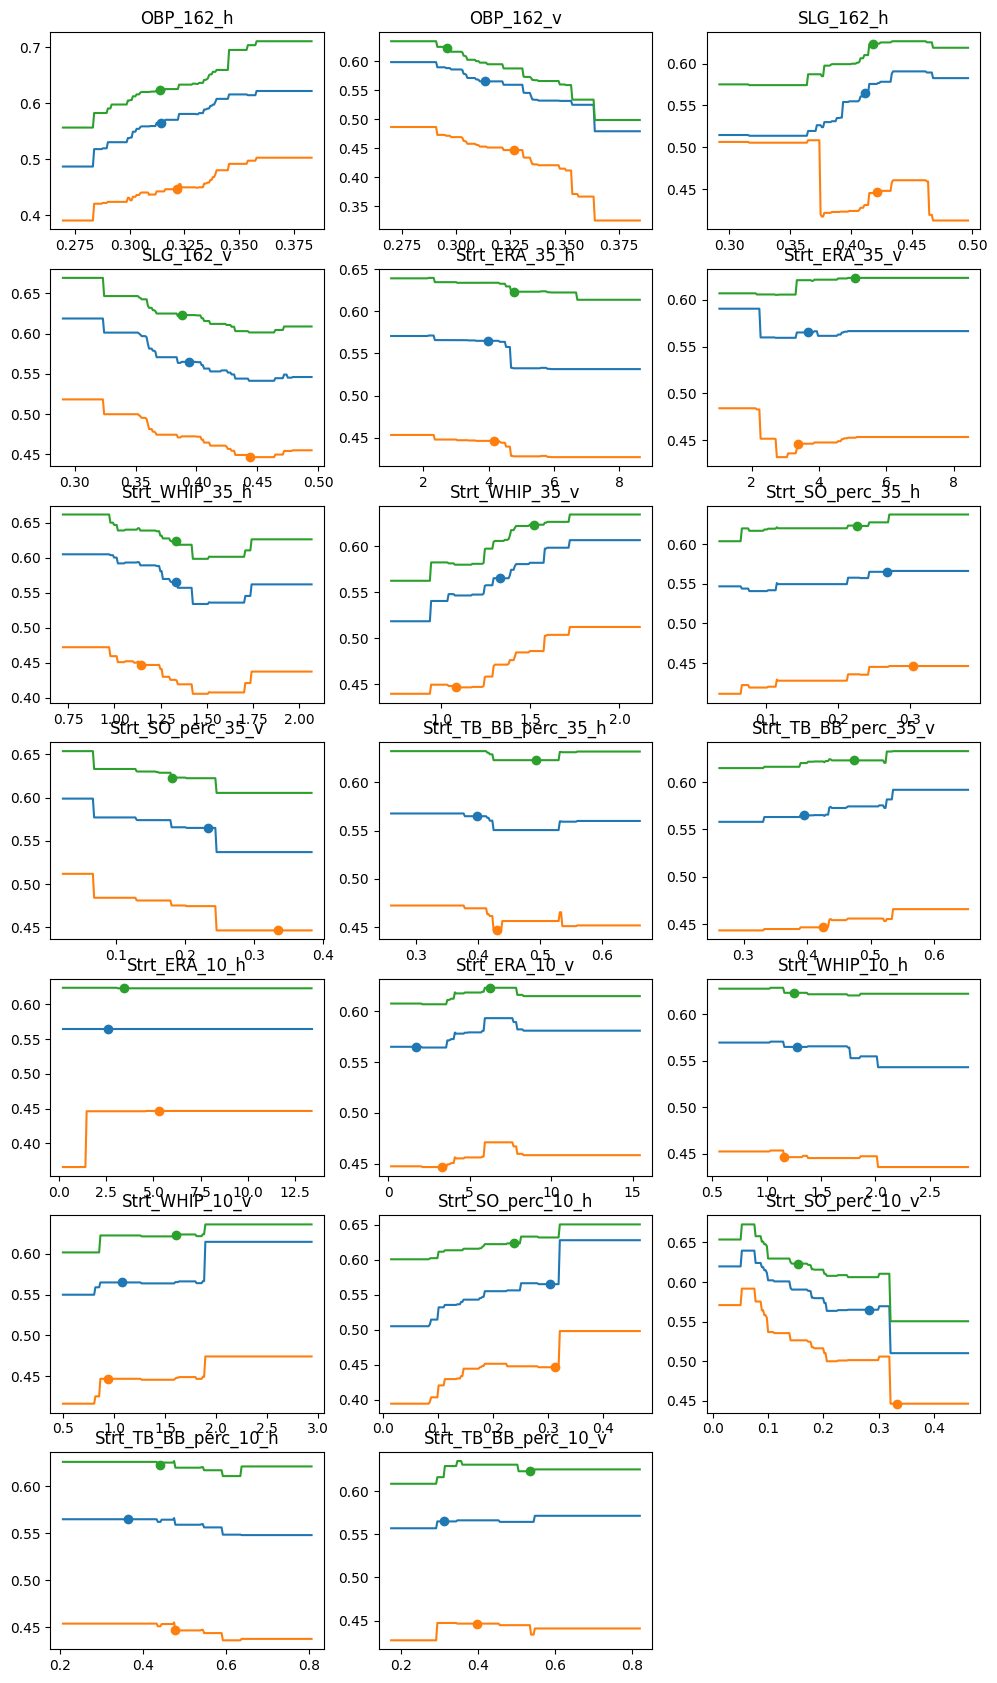

In [43]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

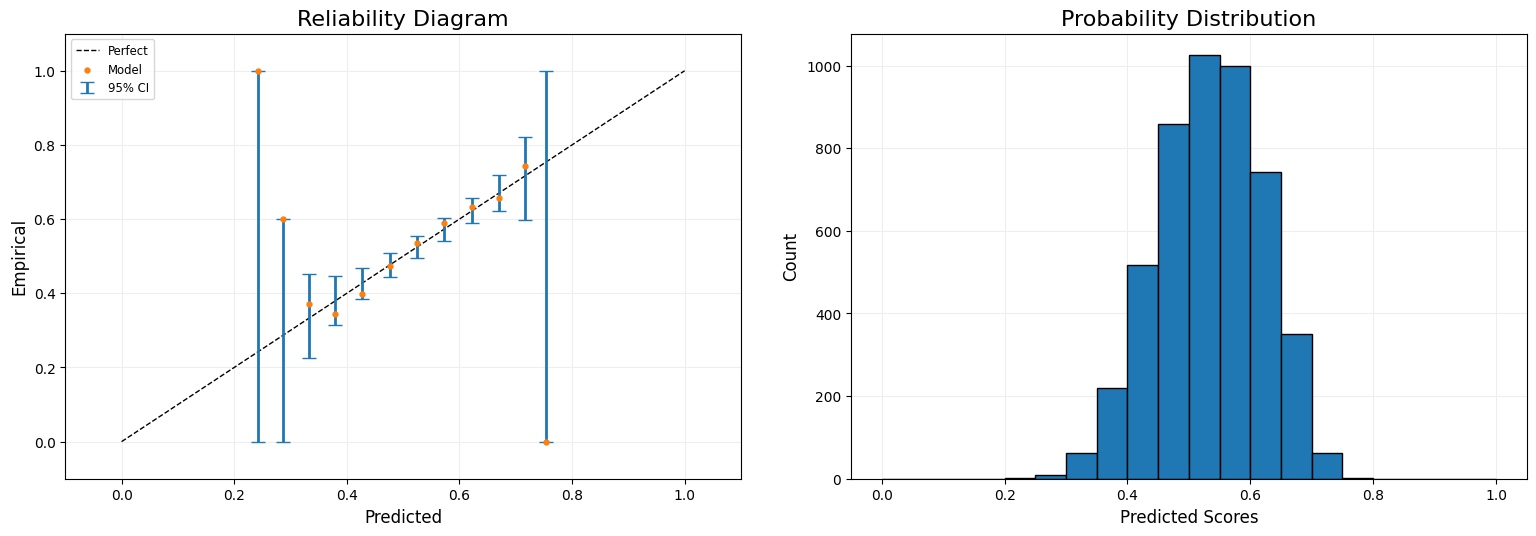

In [44]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [45]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [46]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.159185
Strt_SO_perc_10_v       0.080670
Strt_SO_perc_10_h       0.076855
Strt_WHIP_35_h          0.071194
OBP_162_h               0.071053
OBP_162_v               0.060032
Strt_WHIP_35_v          0.054110
SLG_162_h               0.053193
SLG_162_v               0.042673
Strt_SO_perc_35_v       0.040286
Strt_ERA_35_v           0.028381
Strt_TB_BB_perc_35_h    0.026561
Strt_ERA_35_h           0.021759
Strt_SO_perc_35_h       0.021390
Strt_ERA_10_v           0.019501
Strt_TB_BB_perc_35_v    0.014298
Strt_WHIP_10_h          0.012025
Strt_TB_BB_perc_10_h    0.011453
Strt_TB_BB_perc_10_v    0.007205
Strt_WHIP_10_v          0.004776
Strt_ERA_10_h           0.001847
dtype: float64

In [47]:
# Choose the best window size for each metric, drop ERA
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'

In [48]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [49]:
X_train.shape, X_valid.shape, X_test.shape

((116576, 10), (10611, 10), (4852, 10))

In [50]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689531
[20]	valid_0's binary_logloss: 0.688478
[30]	valid_0's binary_logloss: 0.687541
[40]	valid_0's binary_logloss: 0.686832
[50]	valid_0's binary_logloss: 0.686241
[60]	valid_0's binary_logloss: 0.685658
[70]	valid_0's binary_logloss: 0.685173
[80]	valid_0's binary_logloss: 0.684724
[90]	valid_0's binary_logloss: 0.684453
[100]	valid_0's binary_logloss: 0.684082
[110]	valid_0's binary_logloss: 0.683749
[120]	valid_0's binary_logloss: 0.683451
[130]	valid_0's binary_logloss: 0.683184
[140]	valid_0's binary_logloss: 0.682898
[150]	valid_0's binary_logloss: 0.682635
[160]	valid_0's binary_logloss: 0.68242
[170]	valid_0's binary_logloss: 0.682189
[180]	valid_0's binary_logloss: 0.682005
[190]	valid_0's binary_logloss: 0.681815
[200]	valid_0's binary_logloss: 0.681624
[210]	valid_0's binary_logloss: 0.681483
[220]	valid_0's binary_logloss: 0.681311
[230]	valid_0's binary_logloss: 0.681127
[240]	

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [51]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [52]:
# now about 4 bps worse than previous model..
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6746212409830237, 0.6904962611329533)

In [53]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6675629431340582

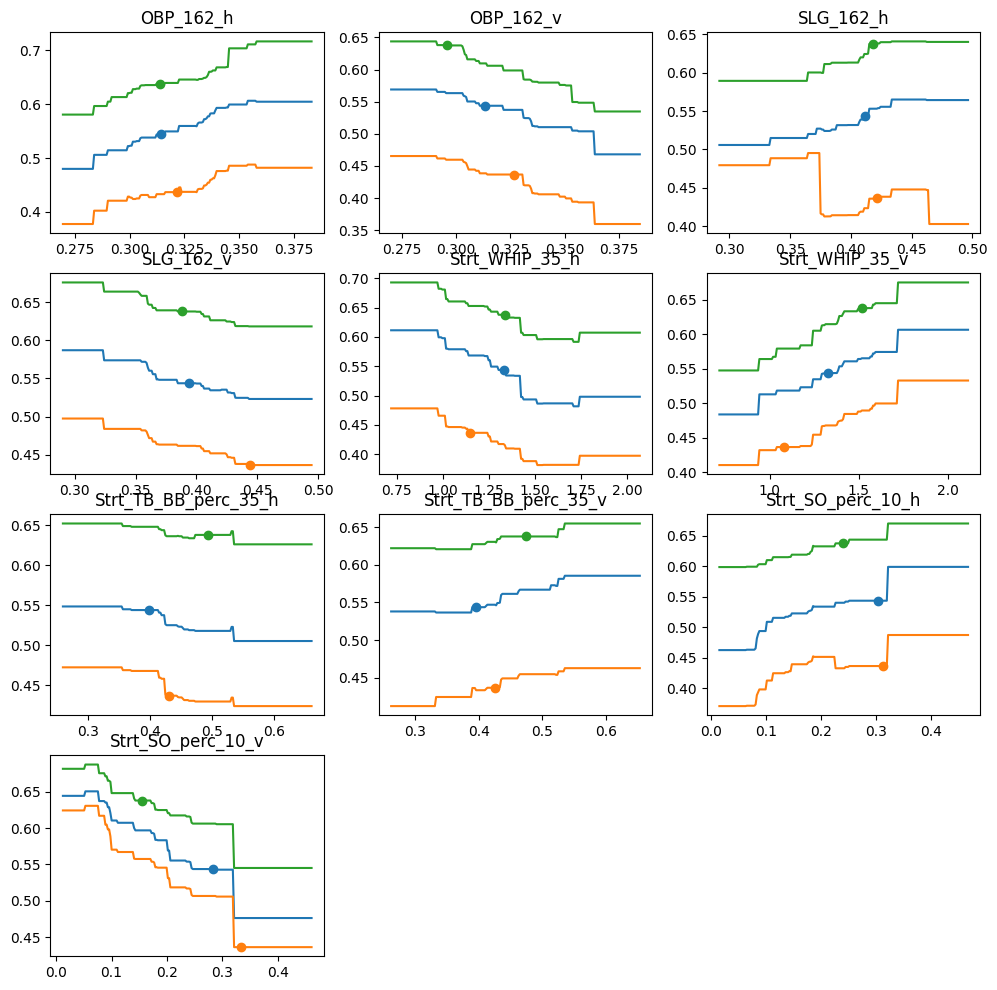

In [54]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

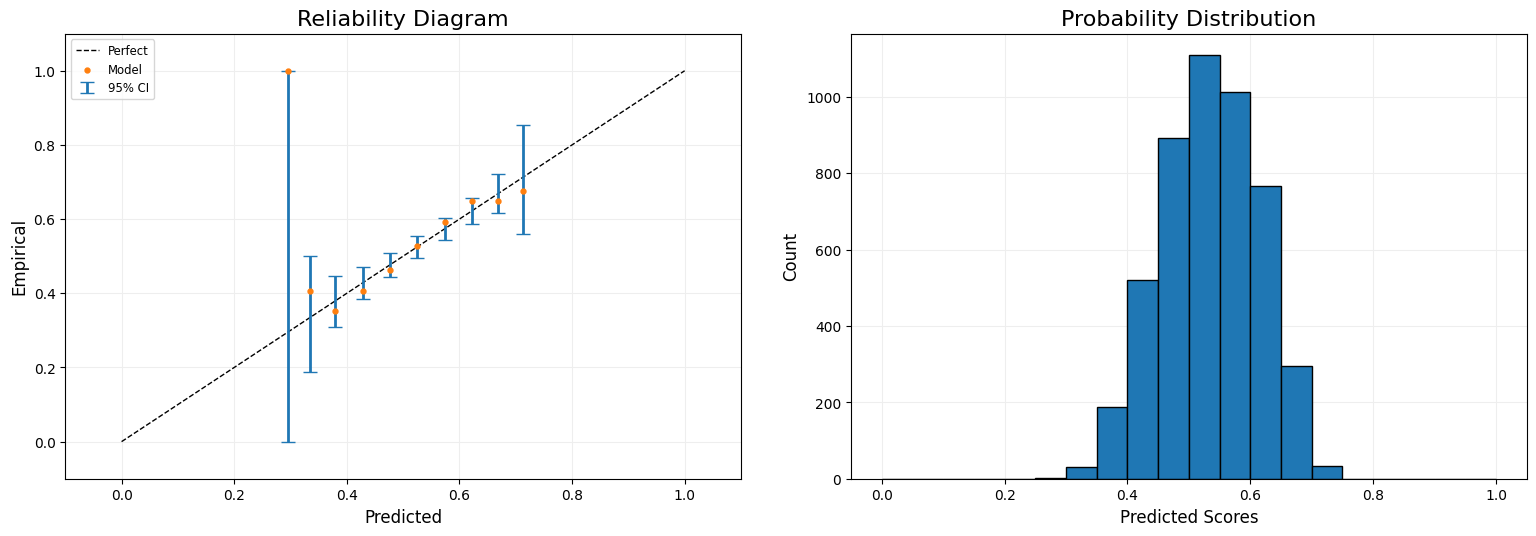

In [55]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [56]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [57]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.159068
Strt_SO_perc_10_v       0.110873
Strt_SO_perc_10_h       0.089107
Strt_WHIP_35_h          0.086580
Strt_WHIP_35_v          0.073114
OBP_162_h               0.068881
OBP_162_v               0.058510
SLG_162_h               0.051199
SLG_162_v               0.041122
Strt_TB_BB_perc_35_h    0.039167
Strt_TB_BB_perc_35_v    0.038956
dtype: float64

How much do these differences in log loss really mean?

When model A does a few bps better than model B in log loss, how should we think about that?

Is it a meaningful improvement?
How do we know it is not just "luck of the draw" of the test set
We'll run some quick simulations to build our intuition about this.

In [58]:
# Simulate a test set (with given "true" probabilities) and compare two models, 
def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [59]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

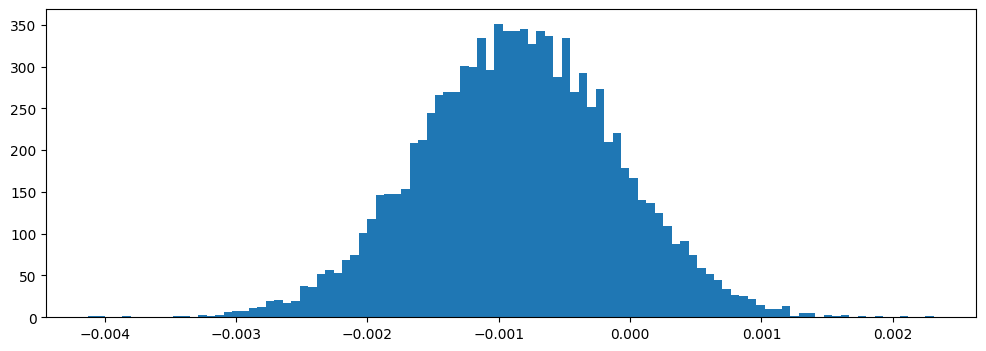

In [60]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

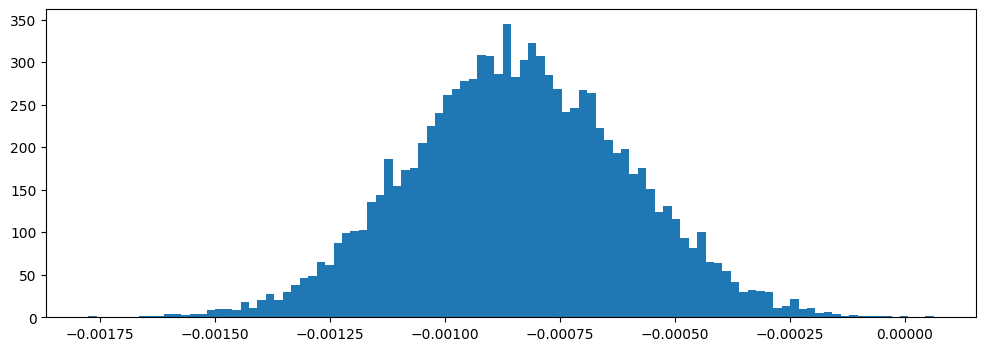

In [61]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [62]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

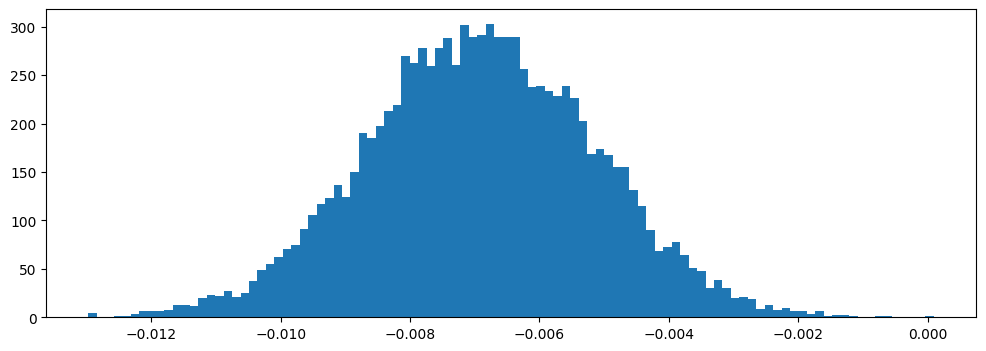

In [63]:

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

Conclusions

    - Could be that 5-10 bps improvement is meaningful!
    - Variation due to test set size is considerable
    - Not a simple matter to increase test set size in this problem
    - For now, still need to improve beyond minor optimizations


Potential Next Steps??

    - Have nothing about the quality of the bullpen
    - Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
    - Could cause an issue with "model drift" (something to explore later on)
    - We don't account for the specific hitting lineup (would need individual batter data)
    - We have nothing about fielding
    - Several additional sources of model drift
    - Rule changes about infield positioning
    - Pitching clock
    - NL now has a DH